# Bug 1795017: recent crash report volume (2023-08-16)

This notebook looks at overall crash report volume over the last 10 weeks that is
contributing to overload of processors and processing backlog.

In [1]:
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

I used [crashstats-tools](https://github.com/willkg/crashstats-tools) to download volume data by product for the last 6 weeks.

```shell
$ supersearchfacet --_facets=product --relative-range=10w --period=daily --format=csv > volume_data.csv
```

Then I graphed the facet data over time.

Text(0, 0.5, 'count')

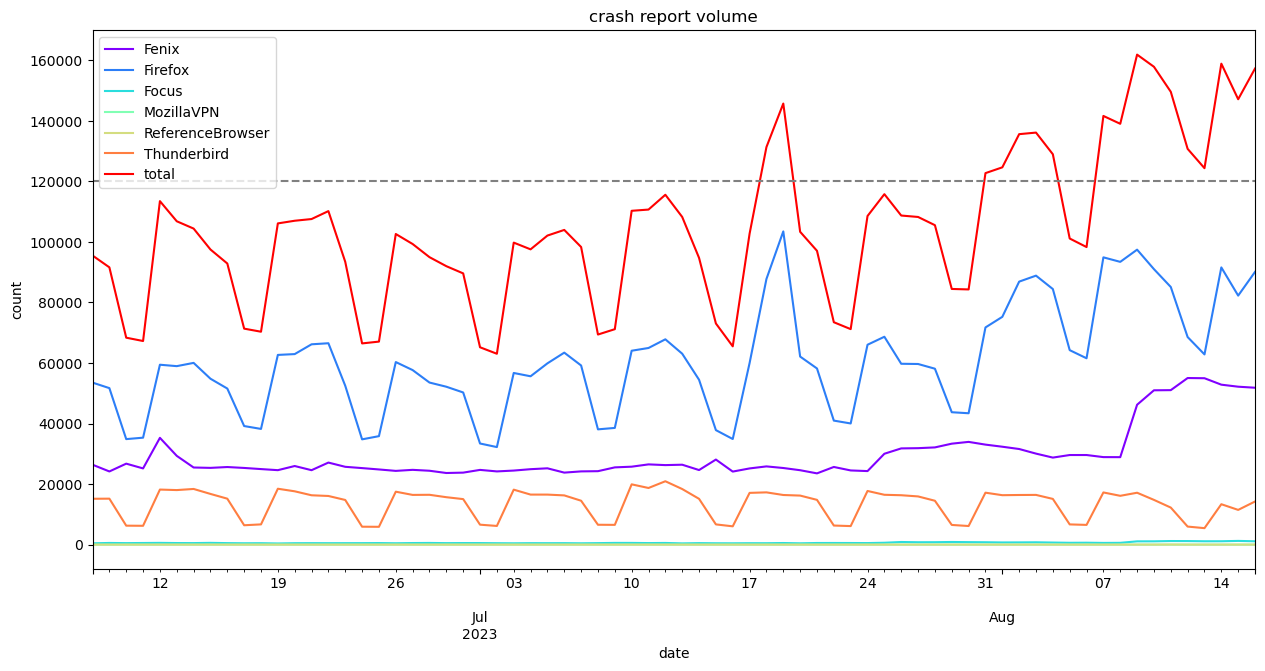

In [2]:
# Data file is a csv with [datetime, timing (ms)];
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1795017_data/volume_data.csv")
products = list(data.columns)
products.remove("date")
products.remove("--")

# print(products)

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

# print(data["dates"].to_string())

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for product in products:
    df = data[product]
    c = next(color)
    df.plot(c=c, xlabel=product, ylabel="count", figsize=(15, 7))

plt.legend()
plt.axhline(y=120000, linestyle="--", color="gray")
plt.title("crash report volume")
plt.xlabel("date")
plt.ylabel("count")